In [ ]:
from src.experiments.Common import load_best_model, load_best_config
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
gpu = 1

sets = {
        "amazon": ["digital_music", "fashion"],
        "pois": ["barcelona", "madrid", "newyorkcity", "paris", "london"],
        "restaurants": ["gijon", "barcelona", "madrid", "newyorkcity" ]# , "paris"],
        }

models = ["BOW2ITM", "USEM2ITM", "BERT2ITM"]

In [ ]:
dataset_emissions = {}

for dataset in sets.keys():
    subset_emissions = {}
    for subset in sets[dataset]:
        model_emissions = {}
        for model in models:
            print(f"{dataset}>{subset}>{model}")
            print("-"*40)
            model_class = load_best_model(model=model, dataset=dataset, subset=subset, gpu=gpu)
            # Cargar las emisiones y eliminar la última fila (está "repetida")
            emissions = pd.read_csv(model_class.MODEL_PATH+"emissions_train.csv")
            emissions.drop(emissions.tail(1).index, inplace=True)
            log = pd.read_csv(model_class.MODEL_PATH+"log.csv")
            recall_column = "RC@10" if "r10" not in log.columns else "r10"
            model_emissions[model] = {"time": log["e_time"].cumsum().values, "loss": log["loss"].values, "co2": emissions["emissions"].values, "r10":log[recall_column].values}

        # plot_emissions(model_emissions)
        subset_emissions[subset.title()] = model_emissions
    dataset_emissions[dataset.title()] = subset_emissions

In [ ]:
def extract_model_values(data, column):
    # Crear un diccionario de listas para cada modelo
    model_values = {}
    # Iterar sobre la lista de diccionarios y agrupar los valores
    for item in data:
        for model, value in item.items():
            model_values[model] = value[column]
    return model_values

def plot_max_value(dataset_emissions, agg_fuction=np.max, column_name="co2", axis_label="Total train emissions (gr)"):

    colors = ['#3F51B5',   '#03A9F4', '#4CAF50', '#3F51B5']

    # Calcular el número de elementos en X para cada dataset
    num_elements = [len(dataset_emissions[dataset].keys()) for dataset in dataset_emissions]

    # Normalizar los anchos de los subplots para que el total sea 1
    total_elements = sum(num_elements)
    relative_widths = [n / total_elements for n in num_elements]

    # Crear una figura con subplots horizontales y anchos personalizados
    fig, axes = plt.subplots(1, len(dataset_emissions), figsize=(sum(num_elements) * 1.5, 3.5), gridspec_kw={'width_ratios': relative_widths}, sharey=False)

    # Iterar sobre los datasets y sus correspondientes ejes
    for plot_idx, (dataset, ax) in enumerate(zip(dataset_emissions.keys(), axes)):
        X = list(dataset_emissions[dataset].keys())
        data = [dataset_emissions[dataset][d] for d in X]
        
        rename = {"Digital_Music": "Music", "Newyorkcity": "New York", "Gijon": "Gijón"}
        X = [rename[d] if d in rename.keys() else d for d in X]

        # Crear un diccionario de listas para cada modelo
        model_values = extract_model_values(data, column_name)
                
        X_axis = np.arange(len(X))
        
        bar_width = 0.7 / len(model_values)  # Ajustar el ancho de las barras
        offset = 0  # Inicializar el desplazamiento
        margin = 0.02
        model_names = {"BOW2ITM":"TeRCEx", "USEM2ITM":"USEM", "BERT2ITM":"BERT"}
        
        for i, (model, values) in enumerate(model_values.items()):
            color = colors[i % len(colors)]  # Seleccionar un color de la lista en función de la posición del modelo
            ax.bar(X_axis + offset - margin, agg_fuction(values), bar_width-margin, label=model_names[model], color=color)
            offset += bar_width  # Incrementar el desplazamiento para el próximo modelo

        ax.set_xticks(X_axis + bar_width * (len(model_values) - 1) / 2)
        ax.set_xticklabels(X)  # Ajustar las etiquetas del eje X
        # ax.set_xlabel("Subsets")
        if plot_idx == 0: ax.set_ylabel(axis_label)
        # ax.set_ylim(0,1)
        ax.set_title(dataset)
        ax.set_axisbelow(True)
        ax.grid(axis="y")
        if plot_idx == len(dataset_emissions.keys())-2: ax.legend(loc=2, mode="expand", ncol=3, bbox_to_anchor=(0.15, -0.15, 0.7, 0))

    # Ajustar el layout para que no se solapen los subplots
    plt.tight_layout()
    plt.show()
    
plot_max_value(dataset_emissions, column_name="r10", axis_label="Recall@10")
plot_max_value(dataset_emissions, column_name="co2", axis_label="Total train emissions (gr)")
# plot_max_value(dataset_emissions, column_name="time", axis_label="Total training time (s)")
# plot_max_value(dataset_emissions, agg_fuction=np.min, column_name="loss", axis_label="Minimum loss")

In [ ]:
def plot_line_plot(dataset_emissions, column_x="time", column_y="loss", x_axis_label="Time", y_axis_label="Loss", ncols=1):
    # Lista de colores
    colors = ['#3F51B5', '#03A9F4', '#4CAF50', '#3F51B5']
    
    # Calcular el número de filas en función del número de subsets
    num_subsets = sum(len(subsets) for subsets in dataset_emissions.values())
    nrows = -(-num_subsets // ncols)  # División redondeada hacia arriba

    # Crear una figura con una matriz de subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3))
    axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar la iteración

    # Contador de gráficos
    plot_idx = 0
    
    # Iterar sobre los datasets y sus subsets
    for dataset, subsets in dataset_emissions.items():
        for subset, data in subsets.items():
            if plot_idx >= len(axes):
                break  # No plot more if we exceed the number of subplots available

            ax = axes[plot_idx]
    
            model_names = {"BOW2ITM": "TeRCEx", "USEM2ITM": "USEM", "BERT2ITM": "BERT"}
        
            for i, (model, model_data) in enumerate(data.items()):
                model_x_values = model_data[column_x]
                model_y_values = model_data[column_y]
                color = colors[i % len(colors)]  # Seleccionar un color de la lista en función de la posición del modelo
                ax.plot(model_x_values, model_y_values, label=model_names.get(model, model), color=color)
    
            # Ajustar las etiquetas del eje X
            ax.set_xlabel(x_axis_label)
            if plot_idx % ncols == 0:
                ax.set_ylabel(y_axis_label)
            #ax.set_title(f"<b>{dataset}</b>: {subset}", fontweight='bold')
            graph_title = r"$\bf{"+dataset+r"}$: " + subset
            ax.set(title=graph_title)
            ax.set_axisbelow(True)
            ax.set_ylim(0,1)
            # ax.legend(loc=2, mode="expand", ncol=3, bbox_to_anchor=(0.15, 0.2, 0.7, 0))

            plot_idx += 1

    # Eliminar subplots no utilizados
    for ax in axes[plot_idx:]:
        fig.delaxes(ax)

    # Mostrar la leyenda solo una vez
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3)

    # Ajustar el layout para que no se solapen los subplots
    plt.tight_layout()
    plt.show()
    
plot_line_plot(dataset_emissions, column_x="co2", column_y="r10", x_axis_label="Emissions (Grams of CO2)", y_axis_label="Recall@10", ncols=6)

/tmp/ipykernel_2794459/333906300.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels([fmt.format(tick) for tick in axis.get_yticks()], ha='center', va='bottom', color='lightgrey', fontweight='bold')
/tmp/ipykernel_2794459/333906300.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels([fmt.format(tick) for tick in axis.get_yticks()], ha='center', va='bottom', color='lightgrey', fontweight='bold')
/tmp/ipykernel_2794459/333906300.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels([fmt.format(tick) for tick in axis.get_yticks()], ha='center', va='bottom', color='lightgrey', fontweight='bold')
/tmp/ipykernel_2794459/333906300.py:39: UserWarning: set_ticklabels() should only be 

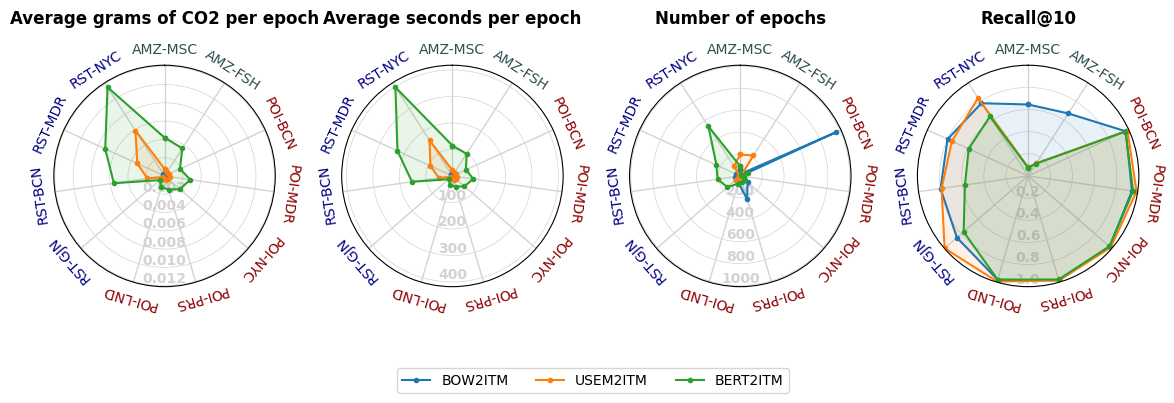

In [295]:
import numpy as np
import matplotlib.pyplot as plt

# Datos de ejemplo para CO2 y R10 para tres modelos y doce datasets
modelos = models # ['Modelo 1', 'Modelo 2', 'Modelo 3']
rnm = {"Amazon":"AMZ-", "Pois":"POI-", "Restaurants":"RST-", "Digital_Music":"MSC", "Fashion":"FSH", "Barcelona":"BCN", "Madrid":"MDR", "Newyorkcity":"NYC", "Paris":"PRS", "London":"LND", "Gijon":"GJN"}
datasets = [rnm[d]+rnm[s] for d in dataset_emissions.keys() for s in dataset_emissions[d].keys()]

# Crear un dataframe con los datos necesarios
plot_data = [ (d, s, m, 
               np.diff(dataset_emissions[d][s][m]["co2"], prepend=0).mean(), 
               np.diff(dataset_emissions[d][s][m]["time"], prepend=0).mean(), 
               len(dataset_emissions[d][s][m]["time"]), 
               dataset_emissions[d][s][m]["r10"].max()) 
             for d in dataset_emissions.keys() for s in dataset_emissions[d].keys() for m in dataset_emissions[d][s].keys()]
plot_data = pd.DataFrame(plot_data, columns=["dataset", "subset", "model", "co2", "time", "epochs", "r10"])
#plot_data["co2"] = plot_data["co2"]*100

# Añadir el primer valor al final para cerrar el ciclo
def cerrar_ciclo(data):
    return np.append(data, data[0])

def plot_radial_data(axis, models, plot_data, column, title="CO2", max_y=None, fmt='{:.3f}'):
    # Gráfico para CO2
    # axis.set_theta_offset(90)  # Rotar 90 grados para alinear el primer dataset
    axis.set_theta_zero_location("N")  # theta=0 at the top
    axis.set_theta_direction(-1)  # theta increasing clockwise

    for modelo in modelos:
        values = plot_data.loc[plot_data["model"] == modelo][column].values
        values = np.append(values, values[0])
        
        theta = np.linspace(0, 2 * np.pi, len(values), endpoint=True)
        axis.fill(theta, values, alpha=0.1)
        axis.plot(theta, values, label=modelo, marker=".")
    axis.set_title(title, pad=30, fontweight="bold")
    
    if max_y is not None: axis.set_ylim(0, max_y)
    axis.set_yticklabels([fmt.format(tick) for tick in axis.get_yticks()], ha='center', va='bottom', color='lightgrey', fontweight='bold')
    axis.set_axisbelow(True)

n_random_items = len(datasets)

# Crear los dos gráficos radiales (polar plots)
fig, axs = plt.subplots(1, 4, subplot_kw=dict(polar=True), figsize=(14,8))

# Ajustar el espacio horizontal entre los gráficos
fig.subplots_adjust(wspace=0.3, top=0.85, bottom=0.15)

# Establecer etiquetas en los r-ticks y rotar las etiquetas para que formen 90 grados con el radio
for ax in axs:
    ax.set_rlabel_position(180)  # get radial labels away from plotted line
    ax.set_xticks(np.linspace(0, 2*np.pi, len(datasets), endpoint=False))
    ax.set_xticklabels(datasets, fontsize=10)
    
    ax.grid(linewidth=1, linestyle = '-', color="lightgrey")
    ax.yaxis.grid(linewidth=0.5, color="lightgrey")

    plt.gcf().canvas.draw()
    angles = np.linspace(0, -2*np.pi, len(ax.get_xticklabels()) + 1)
    angles = np.rad2deg(angles[:-1])
    labels = []
    for label, angle in zip(ax.get_xticklabels(), angles):
        x, y = label.get_position()
        dataset_text = label.get_text()
        dataset_color = "darkred" if "POI" in dataset_text else "navy" if "RST" in dataset_text else "darkslategray"
        # Ajustar la posición de las etiquetas y rotarlas para que formen 90 grados con el radio
        if angle >= 90 and angle <= 270: rotation_angle = angle  - 180
        else: rotation_angle = angle
        lab = ax.text(x, y + 0.035, dataset_text, transform=label.get_transform(), ha='center', va='center', rotation=rotation_angle, color=dataset_color)
        labels.append(lab)
    ax.set_xticklabels([])

# Gráfico para CO2
plot_radial_data(axs[0], modelos, plot_data, fmt='{:.3f}', column="co2", title="Average grams of CO2 per epoch")
# Gráfico para time
plot_radial_data(axs[1], modelos, plot_data, fmt='{:.0f}', column="time", title="Average seconds per epoch")
# Gráfico para epochs
plot_radial_data(axs[2], modelos, plot_data, fmt='{:.0f}', column="epochs", title="Number of epochs")
# Gráfico para R10
plot_radial_data(axs[3], modelos, plot_data, fmt='{:.1f}',max_y=1, column="r10", title="Recall@10")

# Añadir una sola leyenda en el centro abajo
lines, labels = axs[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.51, 0.22), ncol=3)

plt.show()


In [284]:
plot_data

,dataset,subset,model,co2,time,r10
0,Amazon,Digital_Music,BOW2ITM,0.000046,2.899943,0.645550
1,Amazon,Digital_Music,USEM2ITM,0.000776,21.421440,0.077525
2,Amazon,Digital_Music,BERT2ITM,0.004188,114.609077,0.074892
3,Amazon,Fashion,BOW2ITM,0.000043,1.326634,0.671069
4,Amazon,Fashion,USEM2ITM,0.000559,15.068429,0.134273
5,Amazon,Fashion,BERT2ITM,0.003590,99.215675,0.132997
6,Pois,Barcelona,BOW2ITM,0.000021,0.693534,0.970540
7,Pois,Barcelona,USEM2ITM,0.000487,14.264597,0.986808
8,Pois,Barcelona,BERT2ITM,0.001859,56.216574,0.966186
9,Pois,Madrid,BOW2ITM,0.000079,3.184736,0.947395


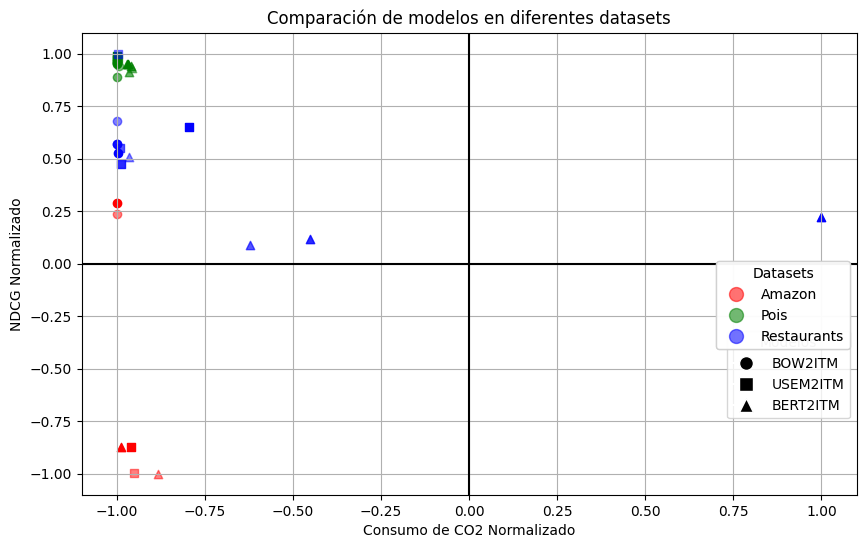

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# Datos de ejemplo en el formato de diccionario especificado
data = dataset_emissions
model_names = models
datasets = list(data.keys())

# Función para normalizar entre -1 y 1
def normalize(values):
    min_val = np.min(values)
    max_val = np.max(values)
    return 2 * (np.array(values) - min_val) / (max_val - min_val) - 1

# Extraer y normalizar los datos
all_co2 = []
all_ndcg = []

for dataset in datasets:
    for subset in data[dataset]:
        for model in model_names:
            all_co2.append(data[dataset][subset][model]["co2"].max())
            all_ndcg.append(data[dataset][subset][model]["r10"].max())

all_co2 = np.array(all_co2)
all_ndcg = np.array(all_ndcg)

# Normalizar a nivel global
normalized_co2 = normalize(all_co2)
normalized_ndcg = normalize(all_ndcg)

# Mapear los datos normalizados de regreso a la estructura original
normalized_data = {}
index = 0

for dataset in datasets:
    normalized_data[dataset] = {}
    for subset in data[dataset]:
        normalized_data[dataset][subset] = {}
        for model in model_names:
            normalized_data[dataset][subset][model] = {
                "co2": normalized_co2[index],
                "ndcg": normalized_ndcg[index]
            }
            index += 1

# Colores base para los datasets
base_colors = ['r', 'g', 'b', 'm', 'c', 'y']
# Variaciones de colores para los subsets
color_idx = 0
colors = []
for dataset in datasets:
    subsets = list(data[dataset].keys())
    colors.append([to_rgba(base_colors[color_idx], alpha=0.5 + i * 0.5 / (len(subsets) - 1)) for i in range(len(subsets))])
    color_idx = (color_idx + 1) % len(base_colors)

# Figuras para los modelos
markers = ['o', 's', '^']

plt.figure(figsize=(10, 6))

# Graficar los puntos
for model_idx, marker in enumerate(markers):
    for dataset_idx, dataset in enumerate(datasets):
        for subset_idx, subset in enumerate(data[dataset]):
            co2_val = normalized_data[dataset][subset][model_names[model_idx]]["co2"]
            ndcg_val = normalized_data[dataset][subset][model_names[model_idx]]["ndcg"]
            plt.scatter(co2_val, ndcg_val,  
                        color=colors[dataset_idx][subset_idx], 
                        marker=marker, 
                        label=f'{model_names[model_idx]}, {dataset} - {subset}' if model_idx == 0 else "")

# Agregar líneas de cuadrantes
plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

# Crear handles para las leyendas
model_handles = [plt.Line2D([0], [0], marker=marker, color='w', markerfacecolor='k', markersize=10, label=model_name) for marker, model_name in zip(markers, model_names)]
dataset_handles = []
subset_handles = []

for dataset_idx, dataset in enumerate(datasets):
    dataset_handles.append(plt.Line2D([0], [0], marker='o', color=colors[dataset_idx][0], linestyle='', markersize=10, label=dataset))
    for subset_idx, subset in enumerate(data[dataset]):
        if subset_idx == 0:
            subset_handles.append(plt.Line2D([0], [0], marker='o', color=colors[dataset_idx][subset_idx], linestyle='', markersize=10, label=f'{dataset} - {subset}'))
        else:
            subset_handles.append(plt.Line2D([0], [0], marker='o', color=colors[dataset_idx][subset_idx], linestyle='', markersize=10, label=subset))

# Agregar las leyendas
legend1 = plt.legend(handles=model_handles, title='Modelos', loc='lower right', bbox_to_anchor=(1, 0.15))
plt.gca().add_artist(legend1)
legend2 = plt.legend(handles=dataset_handles, title='Datasets', loc='lower right', bbox_to_anchor=(1, 0.30))
plt.gca().add_artist(legend2)
# plt.legend(handles=subset_handles, title='Subsets', loc='lower right', bbox_to_anchor=(1, 0.45))

# Agregar etiquetas y título
plt.ylabel('NDCG Normalizado')
plt.xlabel('Consumo de CO2 Normalizado')
plt.title('Comparación de modelos en diferentes datasets')

# Mostrar el gráfico
plt.grid(True)
plt.show()
